# Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import timm
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!nvidia-smi

Tue May 28 02:52:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load Data

In [4]:
batch_size = 32
img_size = 224
model_type = 'region_binary'

data_dir = f'/kaggle/input/region-binary/H'

In [5]:
for folder in os.listdir(data_dir):
    print(folder, len(os.listdir(os.path.join(data_dir, folder))))

normal 29331
disease 22670


In [6]:
from torchvision.transforms import (
    Compose,
    ToTensor
)

transforms = Compose(
        [
            ToTensor()
        ]
    )

In [7]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [8]:
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms)
# valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transforms)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms)

In [9]:
torch.manual_seed(42)

train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
labels = dataset.classes
num_classes = len(labels)
labels

['disease', 'normal']

In [10]:
print(len(train_dataset), len(valid_dataset))

41600 10401


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size*2,
                                          shuffle=True,
                                          num_workers=4)

In [12]:
def imshow(img):

    img = img.numpy().transpose((1, 2, 0))

    # mean = feature_extractor.image_mean
    # std = feature_extractor.image_std
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.show()

1


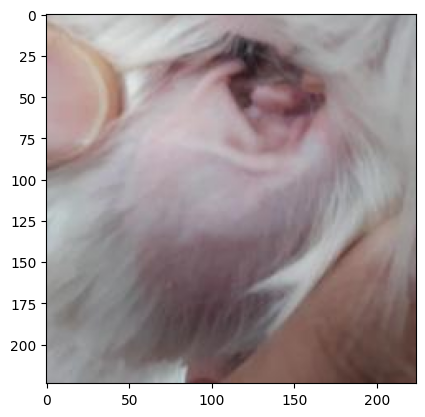

In [13]:
for data in valid_dataset:
    print(data[1])
    imshow(data[0])
    break

# Model Training

In [ ]:
# inception_v4 resnet50 resnetv2_50 efficientnet_b0 inception_resnet_v2
# vit_base_resnet50_224_in21k vit_base_patch16_224 vit_base_patch8_224

In [52]:
model_name = 'inception_resnet_v2'
hidden_size = 1024
pretrained = True
model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [53]:
# model

In [54]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name)

In [55]:
# if pretrained:
#     for i, (name, param) in enumerate(model.named_parameters()):
#         if 'head' in name:
#           print(i, name)
#           break

#         param.requires_grad = False

In [56]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [57]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='lower right')

  plt.show()

In [58]:
class Classifier(nn.Module):
    def __init__(self, model, hidden_size, num_classes=2): 
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return self.sigmoid(x)

In [84]:
classifier = model.to(device)
# classifier = Classifier(model, hidden_size, num_classes=num_classes).to(device)

In [85]:
# for i, (name, param) in enumerate(classifier.named_parameters()):
#     if param.requires_grad:
#       print(i, name)

In [86]:
# optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.01, weight_decay=1e-5) #, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=3)
loss_fn = nn.CrossEntropyLoss()

In [87]:
from collections import OrderedDict
import pickle

def save_checkpoint(epoch, labels, model, optimizer, lr_scheduler,
                    train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                    model_path, filename):
    
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'label': labels
    }
    torch.save(state, os.path.join(model_path, f'{filename}.pt'))

    config = {"train":{"acc":train_acc_epoch, "loss":train_loss_epoch},
          "valid":{"acc":val_acc_epoch, "loss":val_loss_epoch}}

    with open(os.path.join(model_path, f'{filename}.pickle'),'wb') as fw:
        pickle.dump(config, fw)

In [88]:
model_path = f'/kaggle/working/{model_type}'
os.makedirs(model_path, exist_ok=True)

In [89]:
def load_dict(model, optimizer, lr_scheduler, dict_file):
    
    pretrained = torch.load(dict_file)
    
    epoch = pretrained['epoch']
    state_dict = pretrained['state_dict']
    opt_dict = pretrained['optimizer']
    sch_dict = pretrained['lr_scheduler']
    labels = pretrained['label']
    
    model_dict = model.state_dict()
    model_dict.update(state_dict)
    model.load_state_dict(model_dict)
    
    optimizer.load_state_dict(opt_dict)
    lr_scheduler.load_state_dict(sch_dict)
    
    return epoch, labels, model, optimizer, lr_scheduler

In [90]:
import pickle
def load_records(pkl_file):
    with open(pkl_file, 'rb') as f:
        records = pickle.load(f)
    return records['train'], records['valid']

In [91]:
file_path = '/kaggle/working/region_binary'

pretrained = True

In [92]:
num_epochs = 5

best_val_acc, best_val_loss = 0.0, 100.0

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []
lr_epoch = []
epoch_start = 0

classifier = classifier.to(device)

if pretrained:
    dict_file = os.path.join(file_path, f'{model_name}.pt')
    pkl_file = os.path.join(file_path, f'{model_name}.pickle')
    
    epoch_start, labels, model, optimizer, lr_scheduler = load_dict(classifier, optimizer, lr_scheduler, dict_file)
    train_epoch, valid_epoch = load_records(pkl_file)
    train_loss_epoch, train_acc_epoch = train_epoch['loss'], train_epoch['acc']
    val_loss_epoch, val_acc_epoch = valid_epoch['loss'], valid_epoch['acc']

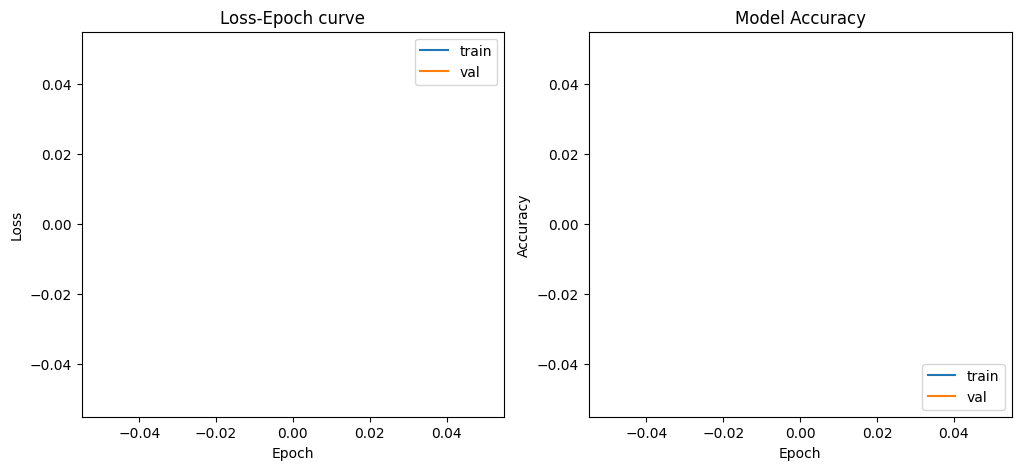

In [93]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [96]:
epoch_start = 5

epoch 10 train acc 0.6145673076923077 validation acc 0.624517800706451


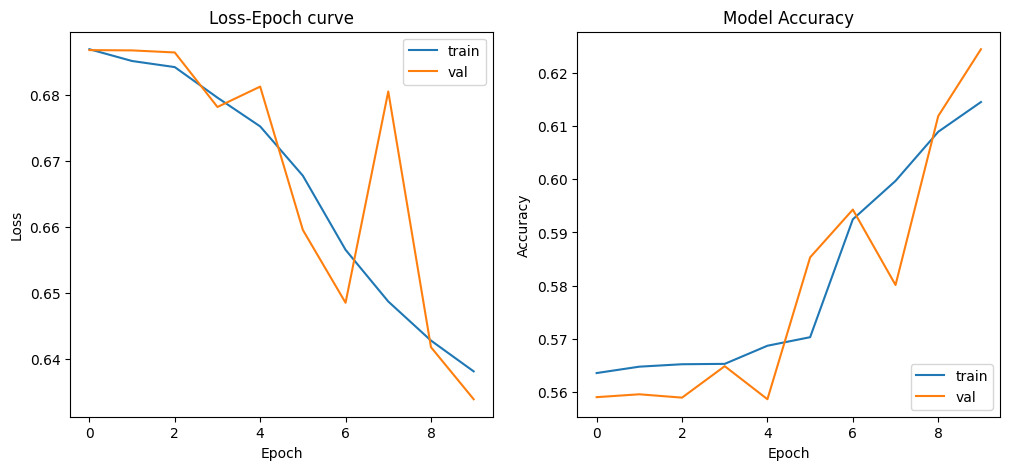

In [97]:
for e in range(epoch_start+1, num_epochs+epoch_start+1):
    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {e}, LR: {lr}')
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    classifier.train()
    for batch_id, batch in enumerate(tqdm.notebook.tqdm(train_loader)):
        optimizer.zero_grad()

        img = batch[0].to(device)
        label = batch[1].to(device) # .squeeze(1) .float()

        out = classifier(img).squeeze(1)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    lr_epoch.append(optimizer.param_groups[0]['lr'])
    print("epoch {} train acc {} loss {}".format(e, tot_train_acc, mean_train_loss))

    classifier.eval()
    with torch.no_grad():
        for batch_id, batch in enumerate(tqdm.notebook.tqdm(valid_loader)):

            img = batch[0].to(device)
            label = batch[1].to(device) # .squeeze(1)

            out = classifier(img).squeeze(1)
            loss = loss_fn(out, label)
            val_loss += loss.item()
            val_acc += calc_accuracy(out, label)
        
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    lr_scheduler.step(mean_val_loss)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      best_val_loss = mean_val_loss
      save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                      train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                      model_path, model_name)

In [ ]:
loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)

In [ ]:
save_checkpoint(e, labels, classifier, optimizer, lr_scheduler,
                train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch,
                model_path, f'{model_name}_{e}epoch')

# Inference

In [ ]:
def inference(img_path):
    
    img = Image.open('/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg')
    encoding = feature_extractor(images=img, return_tensors='pt')
    
    outputs = classifier(encoding['pixel_values'])
    result = outputs.logits.softmax(1)
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[id2label[str(i)]] = value
        
    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)
    
    return result

In [ ]:
# file_path = '/kaggle/input/cv-skin-disease/disease/IMG_C_A2_201354.jpg'
# result = inference(file_path)
# print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')